In [10]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import netCDF4 as netCDF
from IPython.display import Image
from scipy.fftpack import fft, ifft
from scipy import stats
from scipy.stats import norm

# 1. Location of TABS B

# 2. Read and plot the wind data

In [11]:
class Buoy(object):
    "Read the wind data"
    
    def __init__(self, filename):        
        self.filename = filename
        self.time = []
        self.uwind = []
        self.vwind = []      
        file = open(self.filename)
        for line in file:
            line_sp = line.split()
            [month, day, year] = line_sp[0].split('/')
            [hour, minute, second] = line_sp[1].split(':')
            ti = dt.datetime(int(year),int(month),int(day),int(hour),int(minute),int(second))
            self.time.append(ti)
            self.uwind.append(float(line_sp[2]))
            self.vwind.append(float(line_sp[3]))
            
        self.uwind = np.asarray(self.uwind)
        self.vwind = np.asarray(self.vwind)
        self.time  = np.asarray(self.time)
        
    def plot_uv(self,fig,skip=1):
        'plot with skip'
        ax1 = fig.add_subplot(111)
#         ax2 = fig.add_subplot(212)
        ax1.plot(self.time[::skip],self.uwind[::skip],'b')
#         ax2.plot(self.time[::skip],self.vwind[::skip],'g')
        ax1.set_title('a) U Wind')
        ax1.set_ylabel('m/s')
        ax1.set_ylim([-15,15])
        ax1.grid('on')
#         ax2.set_title('b) V Wind')
#         ax2.set_ylabel('m/s')
#         ax2.set_ylim([-15,15])
#         ax2.grid('on')
        
    def fft_wind(self,skip=1):
        dt = float((self.time[1]-self.time[0]).seconds * skip)
        N = len(self.time[::skip])
        T = N*dt
        df = 1./T
        #detrend
        ut = self.uwind[::skip] - np.mean(self.uwind[::skip])
        vt = self.vwind[::skip] - np.mean(self.vwind[::skip])
        fn_u = fft(ut)/T*dt
        fn_v = fft(vt)/T*dt
        sf_u = np.absolute(fn_u)**2
        sf_v = np.absolute(fn_v)**2
        freq = np.asarray([ii*df for ii in range(N)])
        return (fn_u, fn_v, sf_u, sf_v, freq, T, dt, df)

/Users/vrx/miniconda3/envs/owl/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(-1.0385957327138561e-16+0j)

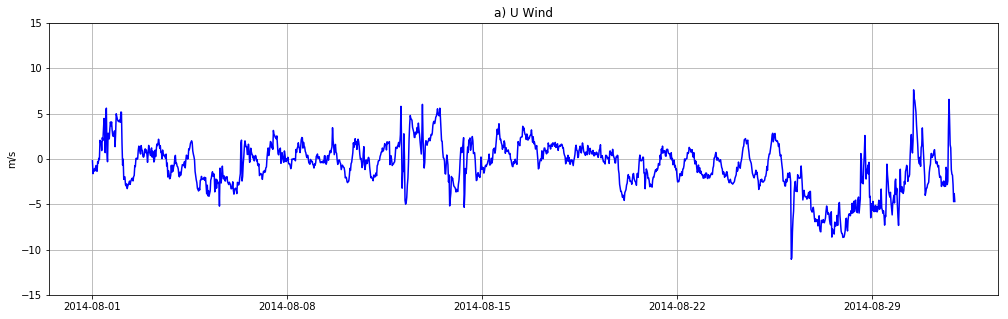

In [3]:
# half-hour data
tabs_b = Buoy('TABS_B_AUG.txt')
fig = plt.figure(figsize=(17,5))
tabs_b.plot_uv(fig)

fn_u_raw, fn_v_raw, sf_u_raw, sf_v_raw, freq_raw,  T_raw, dt_raw, df_raw= tabs_b.fft_wind(skip=1)
fn_u_raw[0]

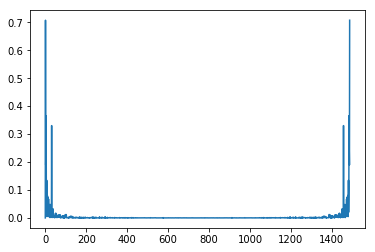

In [14]:
plt.plot(sf_u_raw)

# 3. FFT result

length of fn is 1488
length of data 1488


Text(0,0.5,'Radian')

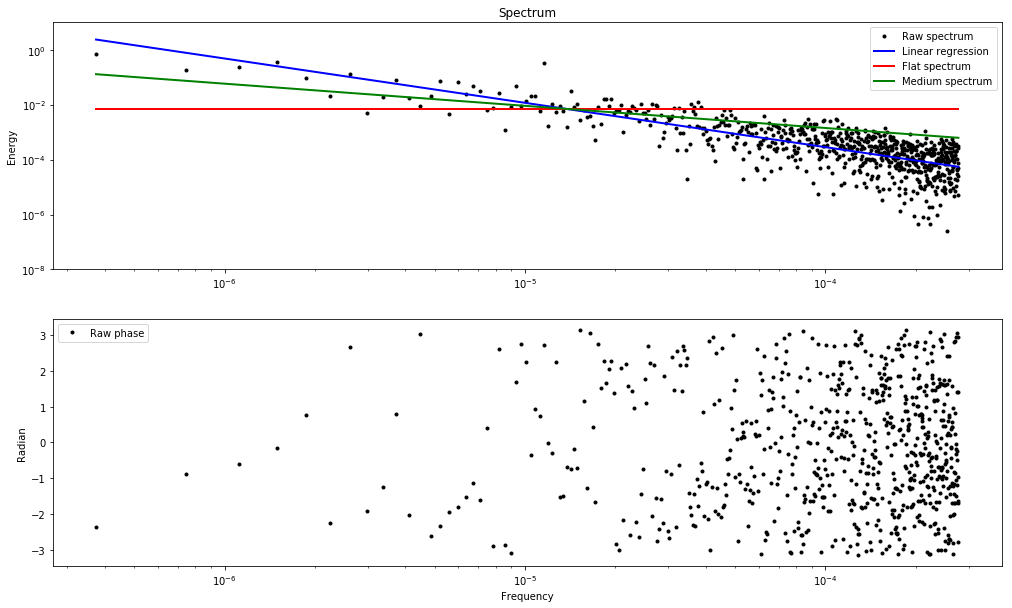

In [7]:
# Raw spectrum
fn_u_raw, fn_v_raw, sf_u_raw, sf_v_raw, freq_raw,  T_raw, dt_raw, df_raw= tabs_b.fft_wind(skip=1)
print('length of fn is', len(fn_u_raw))
print('length of data', len(tabs_b.uwind[:]))

trunc_raw = int(len(freq_raw)/2)
fig = plt.figure(figsize=(17,10))
ax1 = fig.add_subplot(211)
ax1.plot(freq_raw[:trunc_raw],sf_u_raw[:trunc_raw], 'k.',label='Raw spectrum')

# Linear regression
slope, intercept, r_value, p_value, std_err = \
stats.linregress(np.log10(freq_raw[1:trunc_raw]),np.log10(sf_u_raw[1:trunc_raw]))
x_std = freq_raw[1:trunc_raw]
y_std_linear = 10**(slope*np.log10(x_std) + intercept)
y_std_flat = np.mean(y_std_linear)*np.ones_like(x_std)
y_std_medium = 10**(0.5*(np.log10(y_std_linear)+np.log10(y_std_flat)))
ax1.plot(x_std,y_std_linear,'b',label='Linear regression',lw=2)
ax1.plot(x_std,y_std_flat,'r',label='Flat spectrum',lw=2)
ax1.plot(x_std,y_std_medium,'g',label='Medium spectrum',lw=2)
ax1.set_title('Spectrum')
ax1.set_ylabel('Energy')
ax1.legend(numpoints=1)
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_ylim([1.e-8, 10])

# Raw phase
ax2 = fig.add_subplot(212)
phase_u_raw = np.angle(fn_u_raw[:trunc_raw])
ax2.plot(freq_raw[:trunc_raw],phase_u_raw, 'k.',label='Raw phase')
ax2.legend(numpoints=1)
ax2.set_xscale('log')
ax2.set_xlabel('Frequency')
ax2.set_ylabel('Radian')

In [15]:
sf_u_fake = y_std_linear
np.save('spec_recons_linear',sf_u_fake)
np.save('freq_recons',x_std)

In [8]:
fn_u_raw

array([ -1.03859573e-16+0.j        ,  -5.94816382e-01-0.59467157j,
         2.72979805e-01-0.33936187j, ...,   4.06121235e-01+0.27901468j,
         2.72979805e-01+0.33936187j,  -5.94816382e-01+0.59467157j])

# 5. Reconstruction (Same phase)

Text(0,0.5,'Phase (Radian)')

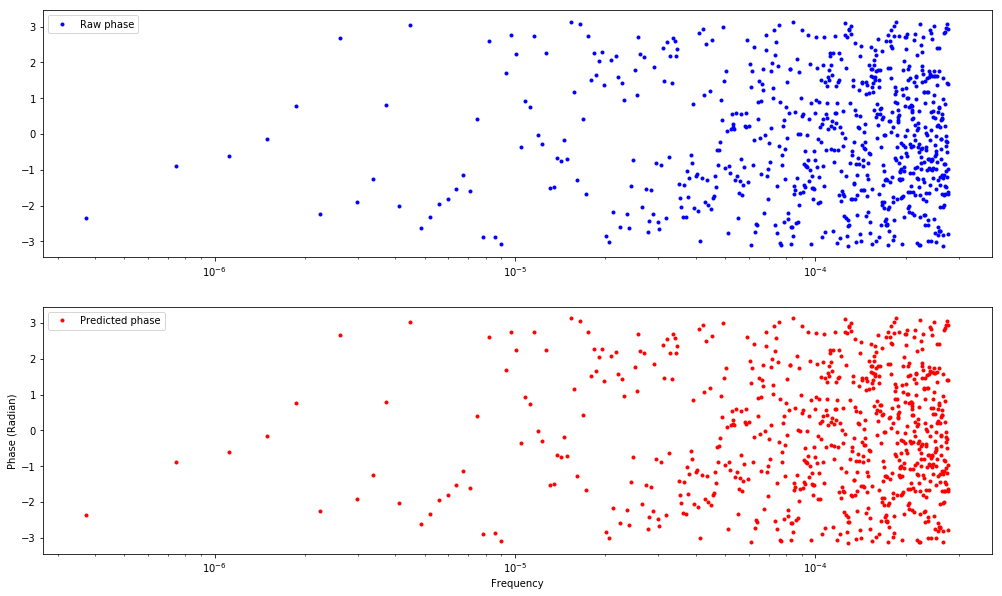

In [16]:
# plot the raw and predicted phase
fig = plt.figure(figsize=(17,10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

phase_u_raw = np.angle(fn_u_raw[:trunc_raw])
ax1.plot(freq_raw[:trunc_raw],phase_u_raw, 'b.',label='Raw phase')
ax1.legend(numpoints=1)
ax1.set_xscale('log')
# ax1.set_ylabel('Phase (Radian)')
# ax1.set_xlim([1e-7, 1e-1])

phase_u_fake = phase_u_raw[1:]
ax2.plot(freq_raw[1:trunc_raw],phase_u_fake,'r.',label='Predicted phase')
ax2.legend(numpoints=1)
ax2.set_xscale('log')
ax2.set_xlabel('Frequency')
ax2.set_ylabel('Phase (Radian)')
# ax2.set_xlim([1e-7, 1e-1])
# print 'length of phaseU_fake is', len(phase_u_fake)

In [27]:
import cmath

fn_u_comb_half = np.asarray([])
fn_u_fake = [cmath.rect(np.sqrt(sf_u_fake)[i],phase_u_fake[i]) 
             for i in range(len(sf_u_fake))]
fn_u_comb_half = np.hstack((fn_u_raw[0],fn_u_fake))


fn_u_comb = np.zeros(2*len(fn_u_comb_half)).astype('complex128')
fn_u_comb[:len(fn_u_comb)/2] = fn_u_comb_half
fn_u_comb[-1:len(fn_u_comb)/2:-1] = np.conj(fn_u_comb_half[1:]) # go to check the HW5_1 of wave


length of recons wind is 1488


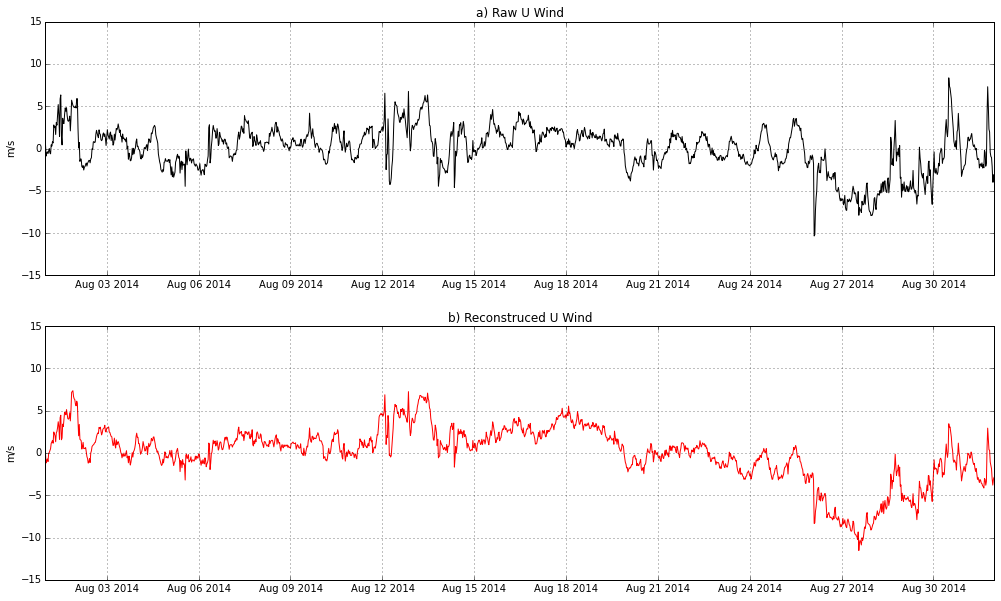

In [29]:
fig = plt.figure(figsize=(17,10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)


ax1.plot(tabs_b.time,ifft(fn_u_raw*T_raw/dt_raw),'k')

#----------------------------
data_recons = ifft(fn_u_comb*len(fn_u_comb))
ax2.plot(tabs_b.time,data_recons,'r')

ax1.set_title('a) Raw U Wind')
ax1.set_ylabel('m/s')
ax1.grid('on')
ax2.grid('on')
ax2.set_title('b) Reconstruced U Wind')
ax2.set_ylabel('m/s')
ax1.set_ylim([-15,15])
ax2.set_ylim([-15,15])

print 'length of recons wind is', len(data_recons)

In [30]:
np.save('phase_recons',phase_u_fake)
np.save('wind_recons',data_recons)